In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plasma-dataset/plasma_dataset/plasma_data.csv
/kaggle/input/plasma-dataset/plasma_dataset/plasma_dataset_analysis.png


=== Plasma Anomaly Detection CNN Training ===
Optimized for Kaggle T4 GPU environment
Using device: cuda
GPU: Tesla T4
CUDA Version: 12.4
Available GPU memory: 14.7 GB

=== Loading Dataset ===
Dataset loaded successfully!
Dataset shape: (2500, 16)

Label distribution:
label
0    2000
1     500
Name: count, dtype: int64
Anomaly ratio: 0.200

Feature columns (13):
   1. b_x_mean
   2. b_y_mean
   3. b_z_mean
   4. b_x_std
   5. b_y_std
   6. b_z_std
   7. b_magnitude_mean
   8. b_magnitude_std
   9. spectral_slope
  10. plasma_beta
  11. field_variability
  12. max_field
  13. min_field

=== Data Preprocessing ===
Training set: 1500 samples
Validation set: 500 samples
Test set: 500 samples
Features scaled using StandardScaler
Data loaders created with batch size: 64

=== Model Initialization ===
Model created with 420,482 total parameters (420,482 trainable)
Using Focal Loss with AdamW optimizer and ReduceLROnPlateau scheduler

=== Training Phase ===
Epoch [  1/100] Train Loss: 0.0185, T

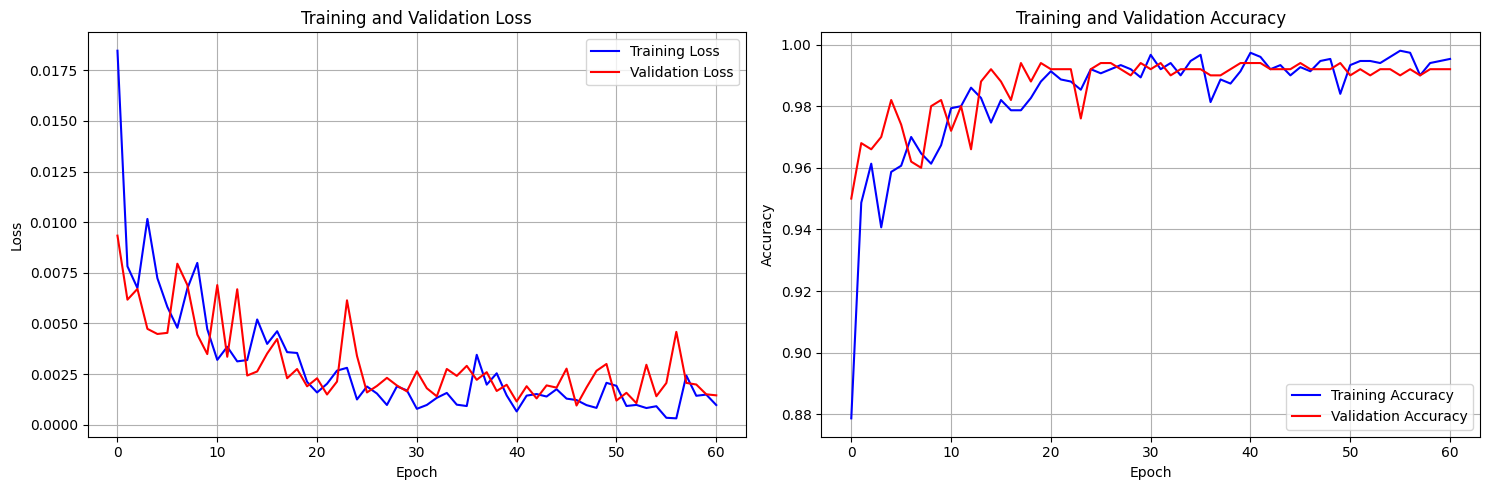

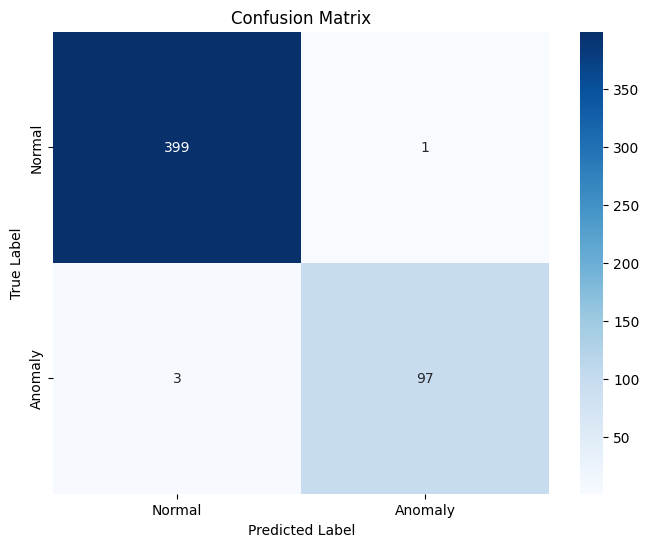

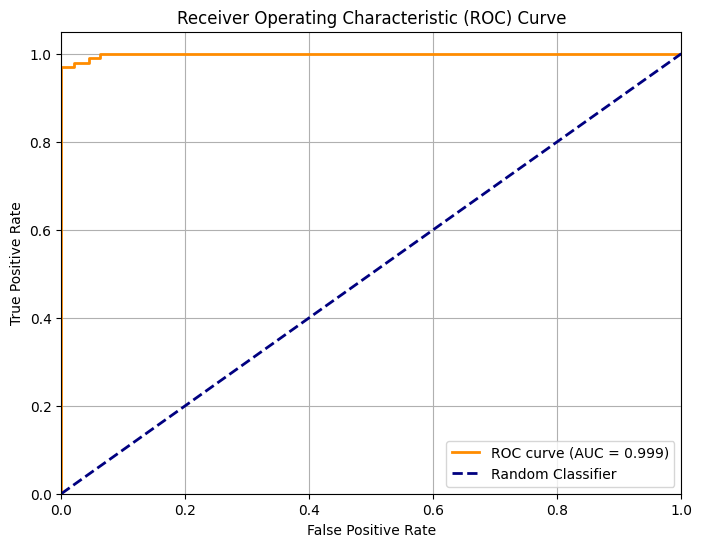


=== Feature Importance Analysis (Corrected) ===
Processed 5/13 features...
Processed 10/13 features...


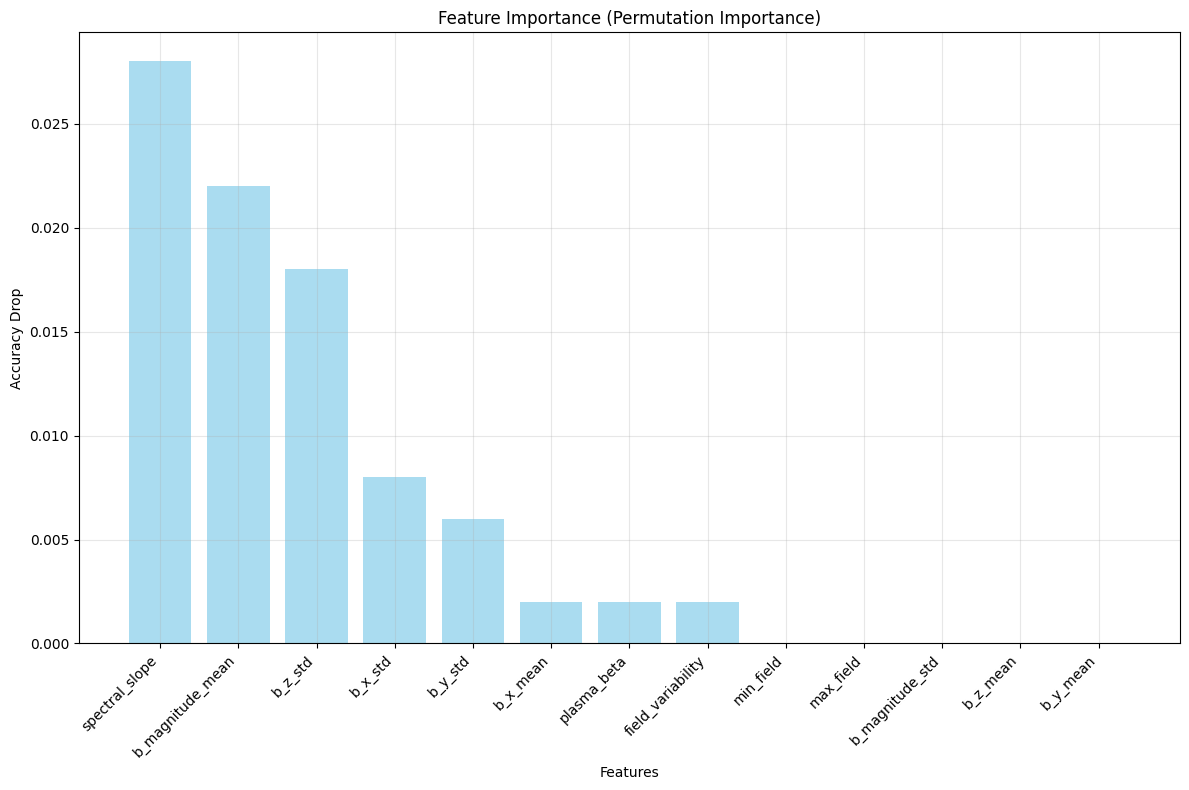


Top 10 Most Important Features:
 1. spectral_slope       | Importance: 0.028000
 2. b_magnitude_mean     | Importance: 0.022000
 3. b_z_std              | Importance: 0.018000
 4. b_x_std              | Importance: 0.008000
 5. b_y_std              | Importance: 0.006000
 6. b_x_mean             | Importance: 0.002000
 7. plasma_beta          | Importance: 0.002000
 8. field_variability    | Importance: 0.002000
 9. min_field            | Importance: 0.000000
10. max_field            | Importance: 0.000000

=== Training Summary ===
Best Validation AUC: 0.9998
Final Test AUC: 0.9987
Training Time: 37.1 seconds
Model saved as: best_plasma_cnn_model.pth
Visualizations saved as PNG files

=== CNN Training Complete ===
Final Test AUC: 0.9987
Ready for LSTM training phase!


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import warnings
import os
import gc
import time
from typing import Tuple, Dict, List
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class PlasmaDataset(Dataset):
    """Custom Dataset for plasma anomaly detection"""
    
    def __init__(self, features: np.ndarray, labels: np.ndarray, transform=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = self.features[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

class PlasmaAnomalyCNN(nn.Module):
    """
    1D CNN for Plasma Anomaly Detection
    Optimized for tabular data with temporal-like features
    """
    
    def __init__(self, input_features: int, num_classes: int = 2, dropout_rate: float = 0.3):
        super(PlasmaAnomalyCNN, self).__init__()
        
        self.input_features = input_features
        
        # Reshape input for 1D CNN (treat features as sequence)
        # Input: (batch_size, input_features) -> (batch_size, 1, input_features)
        
        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        # Reshape input for 1D CNN: (batch_size, features) -> (batch_size, 1, features)
        x = x.unsqueeze(1)
        
        # Convolutional layers with batch normalization and pooling
        x = self.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, kernel_size=2, stride=1, padding=1)
        x = self.dropout(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, kernel_size=2, stride=1, padding=1)
        x = self.dropout(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        return x

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def create_weighted_sampler(labels: np.ndarray) -> WeightedRandomSampler:
    """Create weighted sampler for handling class imbalance"""
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, 
               optimizer: optim.Optimizer, device: torch.device) -> Tuple[float, float]:
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        # Memory cleanup for T4 GPU
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model: nn.Module, val_loader: DataLoader, criterion: nn.Module, 
                  device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """Validate the model for one epoch"""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of anomaly class
    
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy, np.array(all_predictions), np.array(all_targets), np.array(all_probabilities)

def plot_training_history(train_losses: List[float], val_losses: List[float], 
                         train_accuracies: List[float], val_accuracies: List[float]):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true: np.ndarray, y_prob: np.ndarray):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_feature_importance_corrected(model: nn.Module, feature_columns: List[str], 
                                       X_test: np.ndarray, y_test: np.ndarray, device: torch.device):
    """
    Corrected feature importance analysis using permutation importance
    """
    print(f"\n=== Feature Importance Analysis (Corrected) ===")
    
    model.eval()
    
    # Calculate baseline accuracy
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        baseline_outputs = model(X_test_tensor)
        baseline_preds = torch.argmax(baseline_outputs, dim=1).cpu().numpy()
        baseline_accuracy = np.mean(baseline_preds == y_test)
    
    feature_importance_scores = []
    
    # Permutation importance
    for i, feature_name in enumerate(feature_columns):
        # Create a copy of test data
        X_permuted = X_test.copy()
        
        # Permute the i-th feature
        np.random.shuffle(X_permuted[:, i])
        
        # Calculate accuracy with permuted feature
        with torch.no_grad():
            X_permuted_tensor = torch.FloatTensor(X_permuted).to(device)
            permuted_outputs = model(X_permuted_tensor)
            permuted_preds = torch.argmax(permuted_outputs, dim=1).cpu().numpy()
            permuted_accuracy = np.mean(permuted_preds == y_test)
        
        # Importance is the drop in accuracy
        importance = baseline_accuracy - permuted_accuracy
        feature_importance_scores.append(importance)
        
        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1}/{len(feature_columns)} features...")
    
    feature_importance_scores = np.array(feature_importance_scores)
    
    # Create feature importance plot
    plt.figure(figsize=(12, 8))
    indices = np.argsort(feature_importance_scores)[::-1]
    
    # Ensure both arrays have the same length
    x_pos = range(len(feature_columns))
    importance_values = feature_importance_scores[indices]
    
    plt.bar(x_pos, importance_values, color='skyblue', alpha=0.7)
    plt.xticks(x_pos, [feature_columns[i] for i in indices], rotation=45, ha='right')
    plt.title('Feature Importance (Permutation Importance)')
    plt.ylabel('Accuracy Drop')
    plt.xlabel('Features')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance_corrected.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top 10 most important features
    print(f"\nTop 10 Most Important Features:")
    for i in range(min(10, len(feature_columns))):
        idx = indices[i]
        print(f"{i+1:2d}. {feature_columns[idx]:20s} | Importance: {feature_importance_scores[idx]:.6f}")
    
    return feature_importance_scores, indices

def main():
    """Main training function"""
    
    print("=== Plasma Anomaly Detection CNN Training ===")
    print("Optimized for Kaggle T4 GPU environment")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    # Load dataset
    print("\n=== Loading Dataset ===")
    try:
        df = pd.read_csv('/kaggle/input/plasma-dataset/plasma_dataset/plasma_data.csv')
        print(f"Dataset loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        
        # Display basic info
        print(f"\nLabel distribution:")
        print(df['label'].value_counts().sort_index())
        print(f"Anomaly ratio: {df['label'].mean():.3f}")
        
    except FileNotFoundError:
        # Fallback for local testing
        try:
            df = pd.read_csv('plasma_dataset/plasma_data.csv')
            print(f"Dataset loaded from local path!")
            print(f"Dataset shape: {df.shape}")
        except FileNotFoundError:
            # Another fallback
            df = pd.read_csv('plasma_data.csv')
            print(f"Dataset loaded from current directory!")
            print(f"Dataset shape: {df.shape}")
    
    # Prepare features and labels
    feature_columns = [col for col in df.columns if col not in ['sample_id', 'label', 'anomaly_type']]
    X = df[feature_columns].values
    y = df['label'].values
    
    print(f"\nFeature columns ({len(feature_columns)}):")
    for i, col in enumerate(feature_columns):
        print(f"  {i+1:2d}. {col}")
    
    # Check for missing values
    if np.isnan(X).any():
        print("Warning: Found NaN values in features. Filling with median...")
        X = np.nan_to_num(X, nan=np.nanmedian(X, axis=0))
    
    # Split the data
    print(f"\n=== Data Preprocessing ===")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples") 
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print("Features scaled using StandardScaler")
    
    # Create datasets and data loaders
    train_dataset = PlasmaDataset(X_train_scaled, y_train)
    val_dataset = PlasmaDataset(X_val_scaled, y_val)
    test_dataset = PlasmaDataset(X_test_scaled, y_test)
    
    # Create weighted sampler for training
    weighted_sampler = create_weighted_sampler(y_train)
    
    # Data loaders optimized for T4 GPU
    batch_size = 64  # Reduced for T4 GPU memory constraints
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=weighted_sampler,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    print(f"Data loaders created with batch size: {batch_size}")
    
    # Initialize model
    print(f"\n=== Model Initialization ===")
    input_features = X_train.shape[1]
    model = PlasmaAnomalyCNN(input_features=input_features, num_classes=2, dropout_rate=0.3)
    model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model created with {total_params:,} total parameters ({trainable_params:,} trainable)")
    
    # Initialize loss function and optimizer
    # Using Focal Loss to handle class imbalance
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    # Using AdamW optimizer with weight decay
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=0.001, 
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        verbose=True,
        min_lr=1e-6
    )
    
    print("Using Focal Loss with AdamW optimizer and ReduceLROnPlateau scheduler")
    
    # Training loop
    print(f"\n=== Training Phase ===")
    num_epochs = 100
    best_val_auc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 20
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc, val_preds, val_targets, val_probs = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Calculate validation AUC
        val_auc = roc_auc_score(val_targets, val_probs)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - epoch_start_time
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f} | "
                  f"Time: {epoch_time:.1f}s")
        
        # Early stopping and model checkpointing
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_auc': best_val_auc,
                'scaler': scaler
            }, 'best_plasma_cnn_model.pth')
            
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            print(f"Best validation AUC: {best_val_auc:.4f}")
            break
        
        # Memory cleanup
        torch.cuda.empty_cache()
        gc.collect()
    
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.1f} seconds")
    
    # Load best model for evaluation
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation AUC: {best_val_auc:.4f}")
    
    # Final evaluation on test set
    print(f"\n=== Final Evaluation ===")
    test_loss, test_acc, test_preds, test_targets, test_probs = validate_epoch(
        model, test_loader, criterion, device
    )
    
    test_auc = roc_auc_score(test_targets, test_probs)
    
    print(f"Test Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  AUC: {test_auc:.4f}")
    
    # Detailed classification report
    print(f"\nClassification Report:")
    print(classification_report(test_targets, test_preds, 
                              target_names=['Normal', 'Anomaly'], digits=4))
    
    # Create visualizations
    print(f"\n=== Creating Visualizations ===")
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Plot confusion matrix
    plot_confusion_matrix(test_targets, test_preds)
    
    # Plot ROC curve
    plot_roc_curve(test_targets, test_probs)
    
    # Fixed Feature importance analysis using permutation importance
    feature_importance_scores, importance_indices = analyze_feature_importance_corrected(
        model, feature_columns, X_test_scaled, y_test, device
    )
    
    # Summary
    print(f"\n=== Training Summary ===")
    print(f"Best Validation AUC: {best_val_auc:.4f}")
    print(f"Final Test AUC: {test_auc:.4f}")
    print(f"Training Time: {training_time:.1f} seconds")
    print(f"Model saved as: best_plasma_cnn_model.pth")
    print(f"Visualizations saved as PNG files")
    
    return model, scaler, test_auc

if __name__ == "__main__":
    # For Kaggle GPU optimization
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    # Run training
    model, scaler, final_auc = main()
    
    print(f"\n=== CNN Training Complete ===")
    print(f"Final Test AUC: {final_auc:.4f}")
    print("Ready for LSTM training phase!")